# PyTorch Paper Replicating

The goal of ML research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to replicating the Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/pdf/2010.11929

## 0. Get setup

Let's import code we've prepared written and required libraries

In [72]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0+cu121
torchvision version: 0.18.0+cpu


In [73]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

In [74]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [75]:
# Setup device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

The main goal of this is to replicate ViT paper to the FoodVisionMini Problem

In [76]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [77]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [78]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [79]:
from torchvision import transforms
from going_modular import data_setup

# Create image size 
IMG_SIZE = 224 # comes from the table 3 from the paper 

# Create transforms pipeline 
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually create transforms: {manual_transforms}")

Manually create transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [80]:
train_dir

WindowsPath('data/pizza_steak_sushi/train')

In [81]:
# Create a batch size of 32 (the paper uses 4096 but this may be too bif for our smaller hardware.. can always scale up later)
BATCH_SIZE = 32
# Create DataLoaders 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image 

In [82]:
# Get a batch of images 
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch 
image, label = image_batch[0], label_batch[0]

# View the single image nad label shapes 
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

(-0.5, 223.5, 223.5, -0.5)

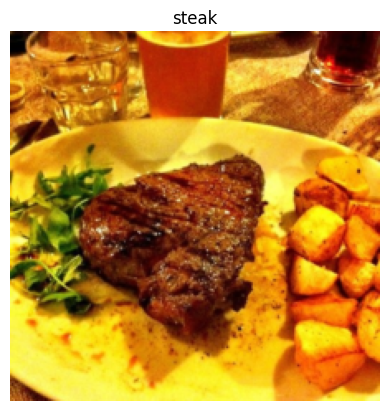

In [83]:
#Plot the image with matplotlib 
import matplotlib.pyplot as plt 

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating the ViT paper: an overview

Before we write any more code, let's discuss what we're doing.

We'd like to replicate the ViT paper for our own problem, FoodVision Mini.

So our **model inputs** are: images of pizza, steak and sushi.

And our ideal **model outputs** are: predicted labels of pizza, steak or sushi.

No different to what we've been doing throughout the previous sections.

The question is: how do we go from our inputs to the desired outputs?

### 3.1 Inputs and outputs, layers and blocks

ViT is a deep learning neural network architecture.

And any neural network architecture is generally comprised of **layers**.

And a collection of layers is often referred to as a **block**.

And stacking many blocks together is what gives us the whole architecture.

A **layer** takes an input (say an image tensor), performs some kind of function on it (for example what's in the layer's `forward()` method) and then returns an output.

So if a **single layer** takes an input and gives an output, then a collection of layers or a **block** also takes an input and gives an output.

Let's make this concrete:
* **Layer** - takes an input, performs a function on it, returns an output.
* **Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* **Architecture (or model)** - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

This ideology is what we're going to be using to replicate the ViT paper.

We're going to take it layer by layer, block by block, function by function putting the pieces of the puzzle together like Lego to get our desired overall architecture.

The reason we do this is because looking at a whole research paper can be intimidating.

So for a better understanding, we'll break it down, starting with the inputs and outputs of single layer and working up to the inputs and outputs of the whole model.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-intputs-outputs-layers-and-blocks.png" alt="inputs and outputs, layers and blocks of a model" width=900/>

*A modern deep learning architecture is usually collection of layers and blocks. Where layers take an input (data as a numerical representation) and manipulate it using some kind of function (for example, the self-attention formula pictured above, however, this function could be almost anything) and then output it. Blocks are generally stacks of layers on top of each other doing a similar thing to a single layer but multiple times.*

### 3.2 Getting specific: What's ViT made of?

There are many little details about the ViT model sprinkled throughout the paper.

Finding them all is like one big treasure hunt!

Remember, a research paper is often months of work compressed into a few pages so it's understandable for it to take of practice to replicate.

However, the main three resources we'll be looking at for the architecture design are:
1. **Figure 1** - This gives an overview of the model in a graphical sense, you could *almost* recreate the architecture with this figure alone.
2. **Four equations in section 3.1** - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
3. **Table 1** - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.

#### 3.2.1 Exploring Figure 1

Let's start by going through Figure 1 of the ViT Paper.

The main things we'll be paying attention to are:
1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.*

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1).
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

You might notice that many of the pieces of the ViT architecture can be created with existing PyTorch layers.

This is because of how PyTorch is designed, it's one of the main purposes of PyTorch to create reusable neural network layers for both researchers and machine learning practitioners.

> **Question:** Why not code everything from scratch?
>
> You could definitely do that by reproducing all of the math equations from the paper with custom PyTorch layers and that would certainly be an educative exercise, however, using pre-existing PyTorch layers is usually favoured as pre-existing layers have often been extensively tested and performance checked to make sure they run correctly and fast.

> **Note:** We're going to be focused on writing PyTorch code to create these layers. For the background on what each of these layers does, I'd suggest reading the ViT Paper in full or reading the linked resources for each layer.

Let's take Figure 1 and adapt it to our FoodVision Mini problem of classifying images of food into pizza, steak or sushi.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>

*Figure 1 from the ViT Paper adapted for use with FoodVision Mini. An image of food goes in (pizza), the image gets turned into patches and then projected to an embedding. The embedding then travels through the various layers and blocks and (hopefully) the class "pizza" is returned.*

#### 3.2.2 Exploring the Four Equations

The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

*These four equations represent the math behind the four major parts of the ViT architecture.*

Section 3.1 describes each of these (some of the text has been omitted for brevity, bolded text is mine):

| **Equation number** | **Description from ViT paper section 3.1** |
| ----- | ----- |
| 1 | ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings**... **Position embeddings** are added to the patch embeddings to retain positional information. We use standard **learnable 1D position embeddings**...|
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we **prepend a learnable embedding to the sequence of embedded patches** $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)... |

Let's map these descriptions to the ViT architecture in Figure 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>

*Connecting Figure 1 from the ViT paper to the four equations from section 3.1 describing the math behind each of the layers/blocks.*

There's a lot happening in the image above but following the coloured lines and arrows reveals the main concepts of the ViT architecture.

How about we break down each equation further (it will be our goal to recreate these with code)?

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer *prime*" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

#### 3.2.4 Equation 2 overview

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a [skip/residual connection](https://paperswithcode.com/method/residual-connection).

We'll call this layer the "MSA block".

In pseudocode, this might look like:

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.5 Equation 3 overview

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.6 Equation 4 overview

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of `x_output_MLP_block`:

```python
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

Of course there are some simplifications above but we'll take care of those when we start to write PyTorch code for each section.

> **Note:** The above section covers alot of information. But don't forget if something doesn't make sense, you can always research it further. By asking questions like "what is a residual connection?".

#### 3.2.7 Exploring Table 1

The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>
<br>

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:
* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture.

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

I remember one of my machine learning engineer friends used to say "it's all about the embedding."

As in, if you can represent your data in a good, learnable way (as **embeddings are learnable representations**), chances are, a learning algorithm will be able to perform well on them.

With that being said, let's start by creating the class, position and patch embeddings for the ViT architecture.

We'll start with the **patch embedding**.

This means we'll be turning our input images in a sequence of patches and then embedding those patches.

Recall that an **embedding** is a learnable representation of some form and is often a vector.

The term learnable is important because this means the numerical representation of an input image (that the model sees) can be improved over time.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):

> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

And size we're dealing with image shapes, let's keep in mind the line from Table 3 of the ViT paper:

> Training resolution is **224**.

Let's break down the text above.

* $D$ is the size of the **patch embeddings**, different values for $D$ for various sized ViT models can be found in Table 1.
* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (**patch size**).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png" width=900 alt="mapping the vit architecture diagram positional and patch embeddings portion to the relative mathematical equation describing what's going on"/>

*Mapping the patch and position embedding portion of the ViT architecture from Figure 1 to Equation 1. The opening paragraph of section 3.1 describes the different input and output shapes of the patch embedding layer.*

### 4.1 Calculating patch embedding input and output shapes by hand

How about we start by calculating these input and output shape values by hand?

To do so, let's create some variables to mimic each of the terms (such as $H$, $W$ etc) above.

We'll use a patch size ($P$) of 16 since it's the best performing version of ViT-Base uses (see column "ViT-B/16" of Table 5 in the ViT paper for more).

In [84]:
# Create example values 
height = 224
width = 224
color_channels = 3
patch_size = 16 

# Calculate number of patches
number_of_patches = int((height*width)/patch_size**2)
number_of_patches

196

In [85]:
# Input shape 
embedding_layer_input_shape = (height , width, color_channels)
# Output shape 
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single  2D image):{embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimensions)")

Input shape (single  2D image):(224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimensions)


### 4.2 Turning single image into a patches 

Text(0.5, 1.0, 'steak')

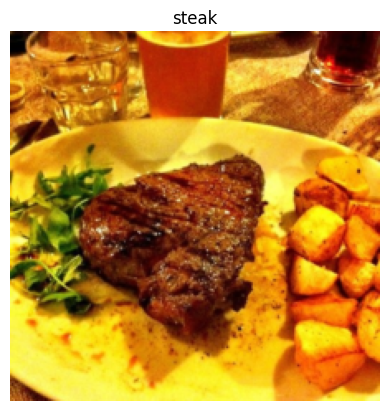

In [86]:
# View a single image 
plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])

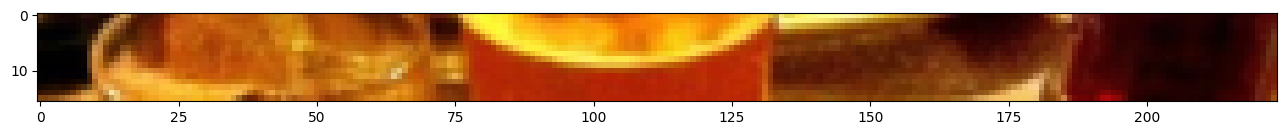

In [87]:
# Get the top row of the image 
image_permuted = image.permute(1,2,0) # Convert image to height, width, color_channel
# Index to  plot the top row of the pixels 
patch_size = 16 
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


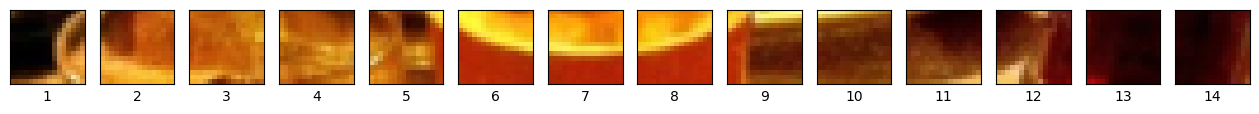

In [88]:
# Setup code to plot top row as patch 
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots 
fig, axs = plt.subplots(nrows=1,
                       ncols=img_size//patch_size,
                       sharex=True,
                       sharey=True,
                       figsize=(patch_size, patch_size))
# Iterate through number of patch in top row 
for i, patch in enumerate(range(0, img_size, patch_size)):
   axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
   axs[i].set_xlabel(i+1)
   axs[i].set_xticks([])
   axs[i].set_yticks([])

Number of patches per row: 14.0      
Number of patch per column: 14.0      
Total patches: 196.0      
Patch size: 16 pixels x 16 pixels


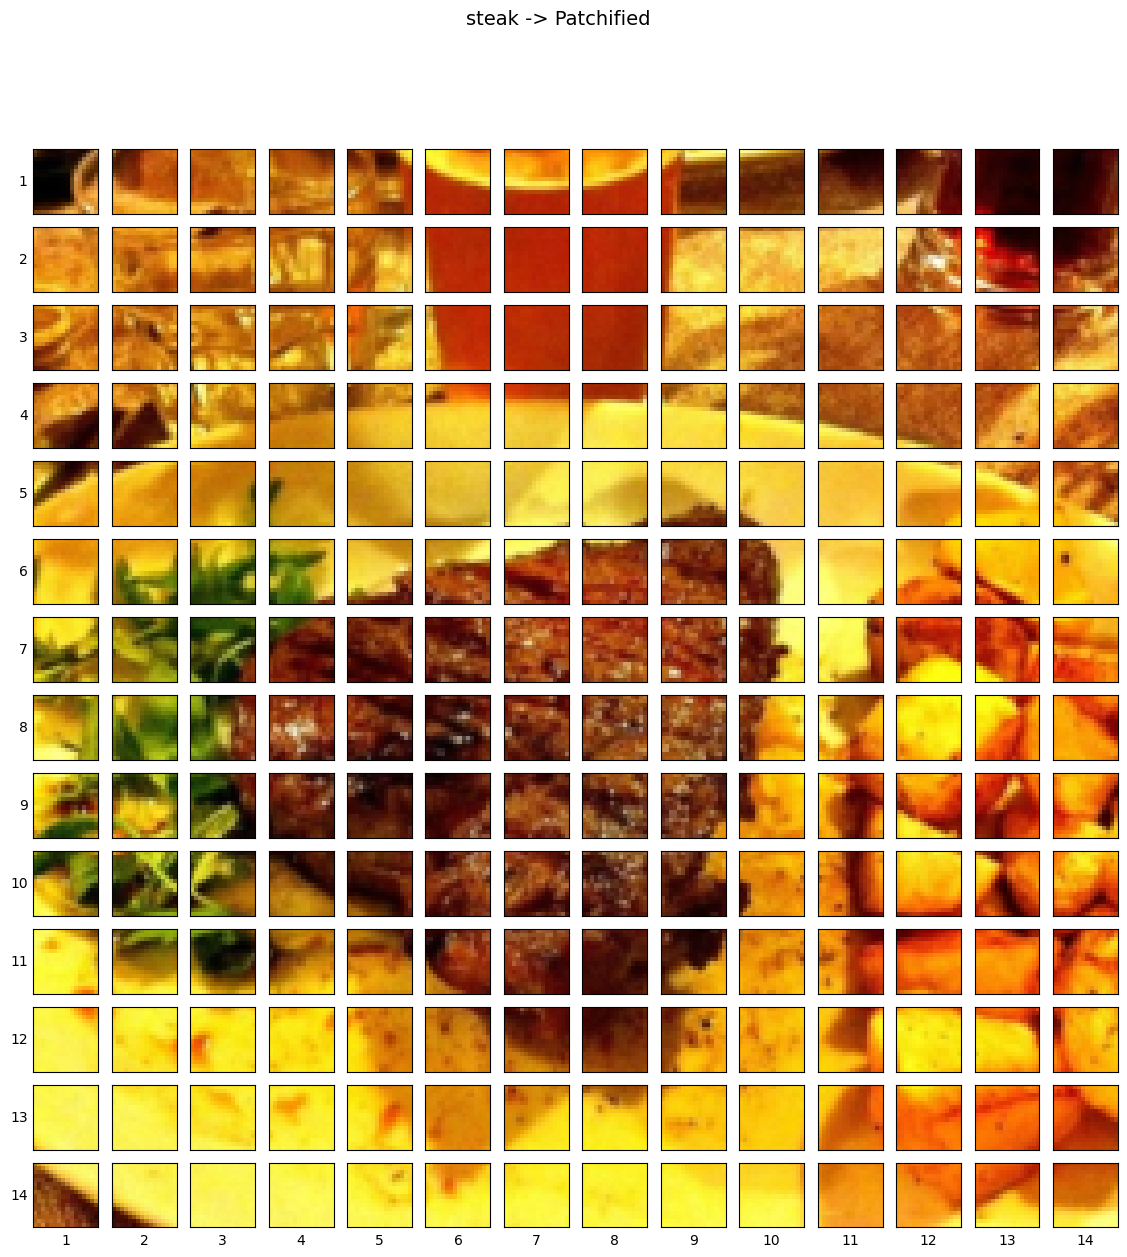

In [89]:
# Setup code to plot whole image as patch 
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
      \nNumber of patch per column: {num_patches}\
      \nTotal patches: {num_patches*num_patches}\
      \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots 
fig, axs = plt.subplots(nrows=img_size//patch_size,
                        ncols=img_size//patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True, 
                        sharey=True)
# Loop through height and width of image 
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image on the different axes
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :])
        # Set up label information for each subplot (patch)
        axs[i,j].set_ylabel(i+1,
                            rotation="horizontal",
                            horizontalalignment="right",
                            verticalalignment="center")
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()
# Setup a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize="14")
plt.show()

### 4.3  Creating image patches and turning them into patch embeddings 

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

In [90]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn 
patch_size = 16
# Create a conv2d layer with hyperparameters from ViT paper 
conv2d = nn.Conv2d(in_channels=3, # For color images
                   out_channels=768, # D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

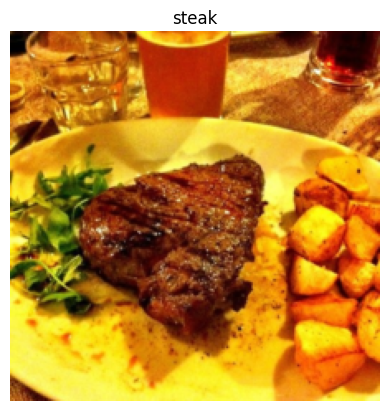

In [91]:
# View single image 
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [92]:
# Pass the image through the convolutional laayer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer, it's shape is: 

```python
torch.Size([1,768,14,14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [315, 638, 60, 711, 564]


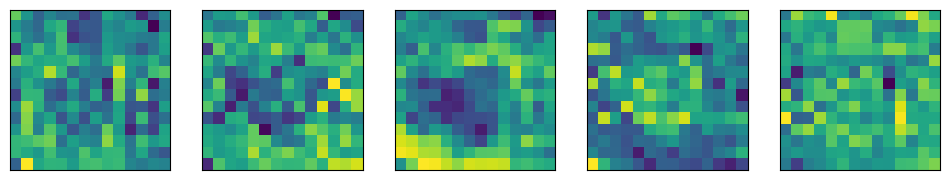

In [93]:
# Plot random convolutional feature maps (embedding)
import random 
random_indexes = random.sample(range(0,786), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")
# Create plot 
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))
#Plot random image feature maps 
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :,:] 
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # Removes batch dimension and remove from grad tracking /switch to numpy
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [94]:
# Get a single feature map in tensor form 
single_feature_map = image_out_of_conv[:, 0, :,:] 
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0993,  0.3688,  0.4275,  0.3583,  0.3625,  0.0571,  0.1222,
            0.1390,  0.1455,  0.0345,  0.0931,  0.3899,  0.1478,  0.0509],
          [ 0.3447,  0.3010,  0.2171,  0.2961,  0.3627,  0.2494,  0.2644,
            0.2671,  0.4995,  0.2818,  0.2175,  0.1571,  0.1650,  0.2393],
          [ 0.1915,  0.2384,  0.3618,  0.5325,  0.3371,  0.2440,  0.2876,
            0.2814,  0.2365,  0.2842,  0.2238,  0.2959,  0.2062,  0.4459],
          [ 0.2764,  0.0487,  0.3578,  0.2981,  0.4601,  0.5042,  0.5732,
            0.6171,  0.4622,  0.4413,  0.4440,  0.3496,  0.4542,  0.0472],
          [ 0.3401,  0.2983,  0.3490,  0.3833,  0.3606,  0.3110,  0.3652,
            0.2498,  0.1409,  0.1347,  0.3322,  0.1784,  0.3948,  0.4438],
          [ 0.4827,  0.3669,  0.1844,  0.2921,  0.1987,  0.0876,  0.1242,
            0.1251,  0.1561,  0.1758,  0.3562,  0.2588,  0.2046,  0.4165],
          [ 0.1489,  0.0742,  0.1201, -0.0138,  0.1152,  0.0537,  0.1878,
            0.3990,  0.2536, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

In [95]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [96]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


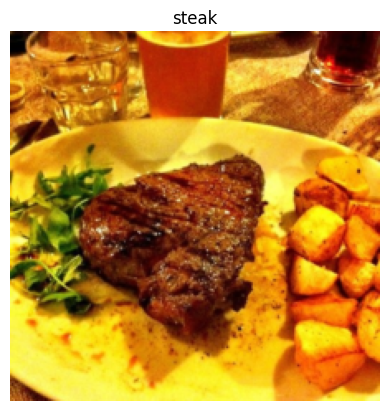

In [97]:
# Put everything together 
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")
# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")
# Flatten the feature maps 
image_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_of_conv_flattened.shape}")

In [98]:
# Rearrange output of flattened layer 
image_of_conv_flattened_permuted = image_of_conv_flattened.permute(0,2,1)
print(f"{image_of_conv_flattened.permute(0,2,1).shape} -> (batch_size, number_of_patches, embedding_dimensions)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimensions)


(-0.5, 195.5, 0.5, -0.5)

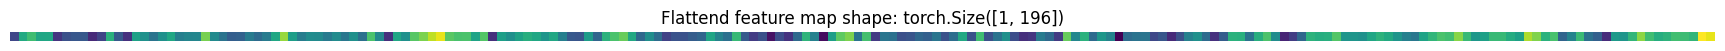

In [99]:
# Get a single flattend feature map 
single_flattened_feature_map = image_of_conv_flattened_permuted[:,:,0]
# Plot the flattend feature map visually 
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattend feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

### 4.5 Turning the ViT patch embedding layer into PyTorch module

We want this module to do few things:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropriate hypermeters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`.
4. Create a layer to flattend the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation(e.g. pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [100]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
    # 2. Initialize the layer with appropriate hyperparameters
    def __init__(self, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 embedding_dim:int=768): # From table 1 for ViT-Base
        super().__init__()
        self.patch_size = patch_size
        # 3. Create a layer to turn an image into embedded patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size)
        # 4. Create a layer to flatten feature map outputs of Conv2d
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
    # 5. Define a forward method to define the forward computation steps
    def forward(self, x):
        # Create assertion to check inputs are the correct shape 
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
        return x_flattened.permute(0,2,1)

In [101]:
set_seeds()
# Create an instance of patch embedding
patchify = PatchEmbedding(in_channels=3,patch_size=16,embedding_dim=768)
# Pass a single image through patch embedding layer 
print(f"Input image size:{image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image size:torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [102]:
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bad = torch.randn(1,3,250,250)
# patchify(rand_image_tensor)

### 4.6 Creating the class token embedding 

Want to:prepand a learnable class token to the start of the patch embedding.

In [103]:
patch_embedded_image

tensor([[[-0.4455,  0.0254, -0.0375,  ...,  0.3707, -0.1871, -0.2136],
         [-0.5054, -0.0353, -0.1142,  ...,  0.3147, -0.2419,  0.2833],
         [-0.5492,  0.0893, -0.0932,  ...,  0.3332, -0.3064,  0.2160],
         ...,
         [-0.6592,  0.0705, -0.1465,  ...,  0.3419, -0.2838,  0.3056],
         [-0.5114,  0.0728, -0.2473,  ...,  0.4808, -0.2925,  0.2827],
         [-0.6211,  0.1471, -0.3050,  ...,  0.4250, -0.2545,  0.3249]]],
       grad_fn=<PermuteBackward0>)

In [104]:
patch_embedded_image

tensor([[[-0.4455,  0.0254, -0.0375,  ...,  0.3707, -0.1871, -0.2136],
         [-0.5054, -0.0353, -0.1142,  ...,  0.3147, -0.2419,  0.2833],
         [-0.5492,  0.0893, -0.0932,  ...,  0.3332, -0.3064,  0.2160],
         ...,
         [-0.6592,  0.0705, -0.1465,  ...,  0.3419, -0.2838,  0.3056],
         [-0.5114,  0.0728, -0.2473,  ...,  0.4808, -0.2925,  0.2827],
         [-0.6211,  0.1471, -0.3050,  ...,  0.4250, -0.2545,  0.3249]]],
       grad_fn=<PermuteBackward0>)

In [105]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [106]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [107]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [108]:
# Add the class token embedding to the front of the patch embedding 
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number_of_patches dimension
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} ->(batch_size, class_token + number_of_patch, embedding_dim)")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4455,  0.0254, -0.0375,  ...,  0.3707, -0.1871, -0.2136],
         [-0.5054, -0.0353, -0.1142,  ...,  0.3147, -0.2419,  0.2833],
         ...,
         [-0.6592,  0.0705, -0.1465,  ...,  0.3419, -0.2838,  0.3056],
         [-0.5114,  0.0728, -0.2473,  ...,  0.4808, -0.2925,  0.2827],
         [-0.6211,  0.1471, -0.3050,  ...,  0.4250, -0.2545,  0.3249]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) ->(batch_size, class_token + number_of_patch, embedding_dim)


### 4.7 Creating the position embedding 

Want to: create a series of 1D learnable embedding  and to add them to sequence of patch embeddings.

In [109]:
# View the sequence of patch embeddings with the prepended class embedding 
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.4455,  0.0254, -0.0375,  ...,  0.3707, -0.1871, -0.2136],
          [-0.5054, -0.0353, -0.1142,  ...,  0.3147, -0.2419,  0.2833],
          ...,
          [-0.6592,  0.0705, -0.1465,  ...,  0.3419, -0.2838,  0.3056],
          [-0.5114,  0.0728, -0.2473,  ...,  0.4808, -0.2925,  0.2827],
          [-0.6211,  0.1471, -0.3050,  ...,  0.4250, -0.2545,  0.3249]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [110]:
# Calculate N (number_of_patches)
number_of_patches = int((height*width)/patch_size**2)
# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
# Create the learnable 1D position embedding 
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1,embedding_dimension), requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [111]:
# Add the position embedding to the patch and class token embedding 
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5545, 1.0254, 0.9625,  ..., 1.3707, 0.8129, 0.7864],
         [0.4946, 0.9647, 0.8858,  ..., 1.3147, 0.7581, 1.2833],
         ...,
         [0.3408, 1.0705, 0.8535,  ..., 1.3419, 0.7162, 1.3056],
         [0.4886, 1.0728, 0.7527,  ..., 1.4808, 0.7075, 1.2827],
         [0.3789, 1.1471, 0.6950,  ..., 1.4250, 0.7455, 1.3249]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embedding.

Now let's see it all in one cell.

In [112]:
# Set seed 
set_seeds()

# 1. Set the patch size 
patch_size = 16 
# 2. Print the shapes of the original image tensor and get the image dimensions 
print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2] 
# 3. Get the image tensor and add a batch dimension 
x = image.unsqueeze(0)
print(f'Input image shape: {x.shape}')
# 4. Create patch embedding layer 
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)
# 5. Pass input image through PatchEmbedding 
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape: {patch_embedding.shape}')
# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f'Class token embedding shape: {class_token.shape}')
# 7. Prepend the class token embedding to patch embedding 
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')
# 8. Create position embedding
number_of_patches = int(height*width) // patch_size**2
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), 
                                  requires_grad=True)
# 9. Add position embedding to patch embedding with class token 
patch_and_position_embedding = patch_embedding_class_token + position_embedding 
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Atention (MSA Block)

* Multihead Self-Attention: which part of a sequence should pay the most attention to itself?
    * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
    * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in Pytorch: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* LayerNorm: Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generatization accuracy.
    * Normalization = make everything have the same mean and same standard deviation.
    * In Pytorch: https://pytorch.org/docs/stable/generated/torch.nn.functional.normalize.html, 
    normalizes values over $D$ dimension, in our case, the $D$ dimension is embedding dimension
        * When we normalize along the embedding dimension, it's like making all of the stairs in staircase the same size

In [113]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Create a multi-head self-attention bloc (MSA Block)"""
    def __init__(self, 
                 embedding_dim:int=768, # Hidden size D (embedding dimensio) from table 1 for Vit-Base
                 num_heads:int=12, # Heads from Table 1 for Vit-Base
                 attn_dropout:int=0):
        super().__init__()
        # Create a norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # Create multihead attention (MSA Layer)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, 
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # is the batch first? (batch, seq, features) -> (batch, number_of_patches, embedding_dimension)

    def forward(self, x):
        x = self.layer_norm(x)
        atten_output, _ = self.multihead_attn(query=x,
                                              key=x,
                                              value=x,
                                              need_weights=False)
        return atten_output

In [114]:
# Create an instance MSA block 
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, 
                                                             num_heads=12,
                                                             attn_dropout=0)
# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print(f'Output of MSA block: {patched_image_through_msa_block.shape}')

Input shape of MSA block: torch.Size([1, 197, 768])
Output of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP block)

* **MLP**: The MLP contains two layers with a GELU non-linearity. (section 3.1).
    * MLP = a quite board term for a block with series of layer(s) , layers can be multiple or even only one hidden layer.
    * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch they're often called `torch.nn.Linear()` and in Tensorflow they might be called `tf.keras.layers.Dense()`
    *  GELU in PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
* **Dropout**: Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.


In pseudocode: 
```python
# MLP 
x = linear -> non-linear -> dropout -> linear -> dropout
``` 

In [115]:
class MLPBlock(nn.Module):
    def __init__(self, 
                 embedding_dim:int=768,
                 mlp_size:int=3072, # number of hidden units
                 dropout:int=0.1):
        super().__init__()
        # Create a norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # Create MLP 
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        # return self.mlp(self.layer_norm(x))

In [116]:
# Create an instance of MLPBlock 
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)
# Pass output of the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'Input of the MLP block: {patched_image_through_msa_block.shape}')
print(f'Output of the MLP block: {patched_image_through_mlp_block.shape}')

Input of the MLP block: torch.Size([1, 197, 768])
Output of the MLP block: torch.Size([1, 197, 768])


## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block

* Encoder = turn a sequence into learnable representation.
* Decoder = go from learn representation back to some sort of sequence.
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevent weights from getting too small)

In pseudocode:

```python
# Transformer Encoder 
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block + [MLP_nlock_output + MSA_block_output + x_input] -> ...
```


### 7.1 Create a custom Transformer Encoder Block

In [117]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, 
                 embedding_dim:int=768, # Hidden size D from table 1, 768 for ViT-Base
                 num_heads:int=12, # from table 1
                 mlp_size:int=3072, # from table 1
                 mlp_dropout:int=0.1, # from table 3
                 attn_dropout:int=0):
        super().__init__()
        # Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim, 
                                  mlp_size=mlp_size, 
                                  dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [118]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()
summary(model=transformer_encoder_block,
        input_size=(1,197,768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]   [1, 197, 768]   --              True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─MultiheadAttention (multihead_attn)         --              [1, 197, 768]   2,362,368       True
├─MLPBlock (mlp_block)                             [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─Sequential (mlp)                            [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─Linear (0)                             [1, 197, 768]   [1, 197, 3072]  2,362,368       True
│    │    └─GELU (1)                               [1, 197,

### 7.2 Create a Transformer Encoder Layer with in-built PyTorch layers

so far we've created a transformer encoder by hand.

But because of how good the transformer architecture is, PyTorch has implemented ready to use Transformer Encoder Layers: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html

We can create a Transformer Encoder with pure PyTorch layers

In [119]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [120]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

What are the benefits of using a pre-built PyTorch layer?

* Less prone to errors (goes through a bunch of testing)
* Potential benefit of speed 

## 8. Putting it all together to create ViT

In [121]:
batch_size = 32
embedding_dim = 768
class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                            requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
class_embedding.shape, class_embedding_expanded.shape

(torch.Size([1, 1, 768]), torch.Size([32, 1, 768]))

In [122]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [123]:
set_seeds()

# Create a random image tensor with same shape as a single image 
random_image_tensor = torch.randn(1,32,224,224)

# Create an instance of ViT  with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(num_classes=3)

# Pass the random image tensor to our ViT instance 
vit(rand_image_tensor)

tensor([[ 0.3361,  0.2240, -1.4273]], grad_fn=<AddmmBackward0>)

### 8.1  Getting a visual summary of our ViT model

In [124]:
from torchinfo import summary 

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for our custom ViT

we've replicated the ViT architecture , now let's see how it performs on our FoodVision Mini data.

### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4, Training & Fine-tuning) with $B1$ value of 0.9 and $B2$ of 0.999 (defaults) and weight decay of 0.1.

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique = prevents overfitting. 

In [125]:
optimizer = torch.optim.Adam(vit.parameters(), 
                             lr=1e-3,
                             betas=(0.9,0.999),
                             weight_decay=0.1)

### 9.2 Creating a loss function

The ViT paper doesn't actually mention what loss function they used.

So since it's a  multi-class classification we'll use the `torch.nn.CrossEntropyLoss()`.

In [126]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Train our ViT model

In [127]:
torch.cuda.is_available()

True

In [128]:
# Setup device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [129]:
from going_modular import engine 

set_seeds()

results = engine.train(model=vit, 
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7545 | train_acc: 0.3711 | test_loss: 1.1838 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1465 | train_acc: 0.4219 | test_loss: 2.6441 | test_acc: 0.2604
Epoch: 3 | train_loss: 2.0147 | train_acc: 0.2852 | test_loss: 1.4513 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.7859 | train_acc: 0.2734 | test_loss: 1.2708 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3097 | train_acc: 0.2852 | test_loss: 1.0383 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.2256 | train_acc: 0.2930 | test_loss: 1.2893 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1945 | train_acc: 0.3945 | test_loss: 2.6886 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4505 | train_acc: 0.3047 | test_loss: 1.2568 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.2792 | train_acc: 0.2461 | test_loss: 1.1299 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.3102 | train_acc: 0.4297 | test_loss: 1.4247 | test_acc: 0.2604


### 9.4 What our training setup is missing

How is our training setup different to  the ViT paper? 

We've replicated model architecture correctly. 

But what was different between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results

Prevent undefitting:

The main things our training implementation is missing: 
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting:
* Learning rate warmup - start with a low learning rate and increase to a base LR
* Learning rate decay - as model gets closer to convergence, start to lower the learning rate
* Gradient clipping - prevent gradients from getting too big 

### 9.5 Plotting loss curves for our model 

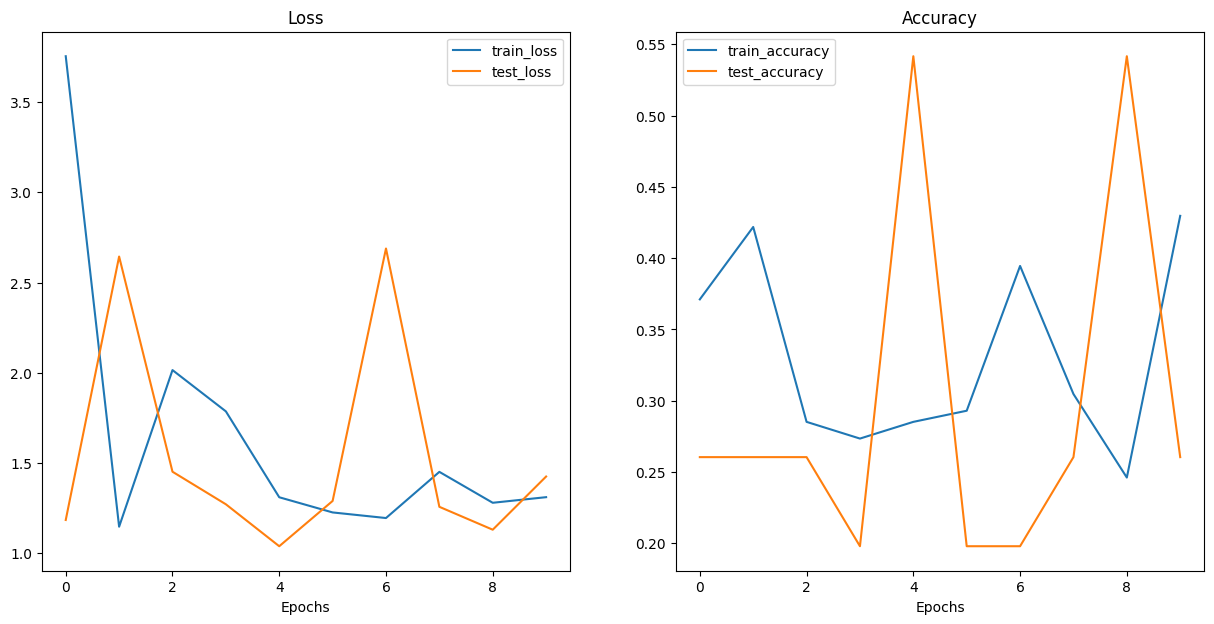

In [130]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretrained ViT from `torchvision.models`

Generally, in deep learning if you can a pretrained model from a laarge dataset on your own problem, it's often a good place to start.

If you can find a pretrained model, and use transfer learning, it often achieves great results with little data.

### 10.1 Why use a pretrained model?

* Sometimes data is limited 
* Limited training resources
* Get better results faster

In [131]:
import torch 
import torchvision 
print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cpu


In [132]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [133]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULt" = best available

# Setup a ViT model instance with pretrained weights 
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters 
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Update the classifier head 
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [134]:
from torchinfo import summary 

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, make sure data is formatted in the same way that the model was trained on..

In [135]:
# Get automatic transforms from pretrained ViT weights 
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [138]:
# Setup dataloaders 
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                      test_dir=test_dir,
                                                                                                      transform=vit_transforms,
                                                                                                      batch_size=32) # Could set a higher batch size because using a pretrained model 

In [139]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names

(<torch.utils.data.dataloader.DataLoader at 0x294cb096780>,
 ['pizza', 'steak', 'sushi'])

### 10.4 Train feature extractor ViT model 

In [140]:
device

'cuda'

In [141]:
from going_modular import engine 

# Create optimizer and loss function  
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()

pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer, 
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5  Plot the loss curves of our pretrained ViT feature extractor model 

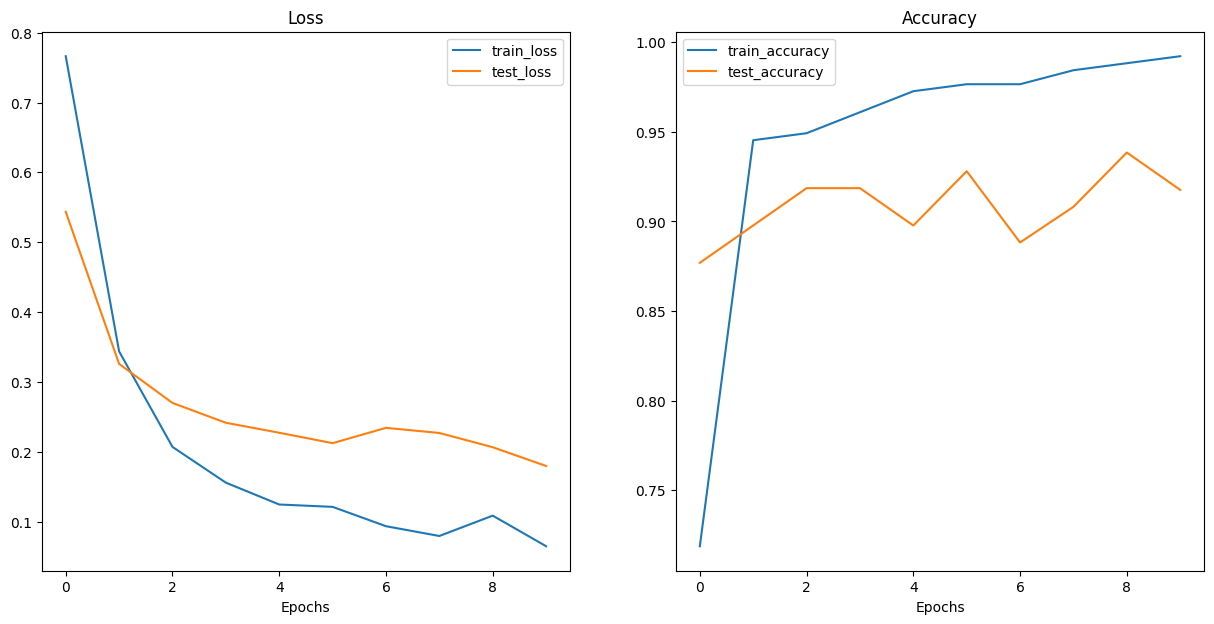

In [142]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing ViT model 

Now we've got a model that performs quite well, now save the model and check its filesize.

We want to check the filesize because if we want to deploy a model to a website/mobile application, we may have limitations on the size of the model we can deploy. 

E.g. a smaller model may be required due to compute restrictions 

In [143]:
# Save the model 
from going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_pizza_sterak_sushi.pth")

[INFO] Saving model to: models\pretrained_vit_feature_extractor_pizza_sterak_sushi.pth


In [145]:
from pathlib import Path 

# Get the model size in bytes then convert to megabytes 
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_sterak_sushi.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained Vit feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained Vit feature extractor model size: 327 MB


## 11. Predicting in custom image

In [146]:
image_path

WindowsPath('data/pizza_steak_sushi')

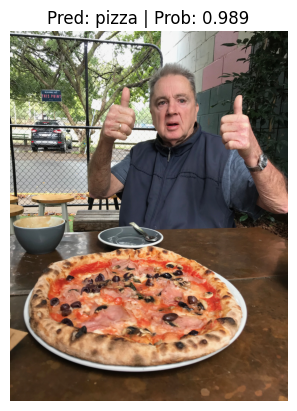

In [148]:
import requests

# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)